##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Step 2: Train a machine learning model

This is the notebook for step 2 of the codelab [**Build a handwritten digit classifier app with TensorFlow Lite**](https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Import dependencies

We start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
print(tf.__version__)

2.3.0


## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [ ]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


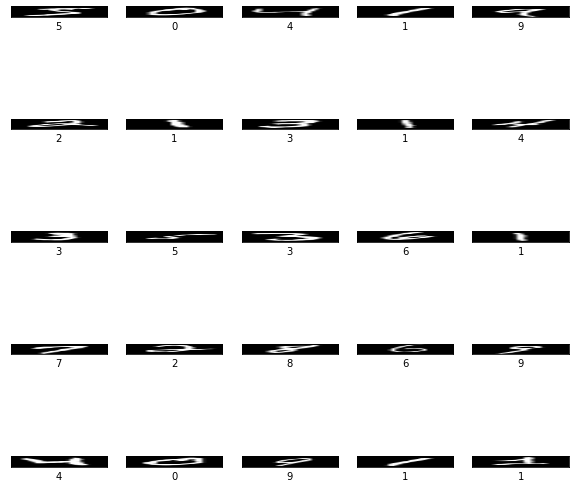

In [ ]:

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])

  image = cv.resize(train_images[i],dsize=(100,11), interpolation = cv.INTER_LINEAR)
  plt.imshow(image,cmap=plt.cm.gray)
#   plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [ ]:
train_ds = np.empty([len(train_images),11,100])

for i in range(len(train_images)):
    train_ds[i,:,:] = cv.resize(train_images[i], dsize=(100,11), interpolation = cv.INTER_LINEAR)

test_ds = np.empty([len(test_images),11,100])

for i in range(len(test_images)):
    test_ds[i,:,:] = cv.resize(test_images[i], dsize=(100,11), interpolation = cv.INTER_LINEAR)

## Train a TensorFlow model to classify digit images

Next, we use Keras API to build a TensorFlow model and train it on the MNIST "train" dataset. After training, our model will be able to classify the digit images.

Our model takes **a 28px x 28px grayscale image** as an input, and outputs **a float array of length 10** representing the probability of the image being a digit from 0 to 9.

Here we use a simple convolutional neural network, which is a common technique in computer vision. We will not go into details about model architecture in this codelab. If you want have a deeper understanding about different ML model architectures, please consider taking our free [TensorFlow training course](https://www.coursera.org/learn/introduction-tensorflow).

In [ ]:


model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(11, 100)),
  tf.keras.layers.Reshape(target_shape=(11, 100, 1)),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Train the digit classification model
model.fit(train_ds, train_labels, epochs=5)



Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2508 - accuracy: 0.9252
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1346 - accuracy: 0.9602
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0985 - accuracy: 0.9704
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0793 - accuracy: 0.9761
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0698 - accuracy: 0.9785


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 11, 100, 1)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 98, 16)         160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 96, 32)         4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 48, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 48, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

Let's take a closer look at our model structure.

There is an extra dimension with **None** shape in every layer in our model, which is called the **batch dimension**. In machine learning, we usually process data in batches to improve throughput, so TensorFlow automatically add the dimension for you.

## Evaluate our model
We run our digit classification model against our "test" dataset that the model has not seen during its training process to confirm that the model did not just remember the digits it saw but also generalize well to new images.

In [ ]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_ds, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0640 - accuracy: 0.9809
Test accuracy: 0.98089998960495


Although our model is relatively simple, we were able to achieve good accuracy around 98% on new images that the model has never seen before. Let's visualize the result.

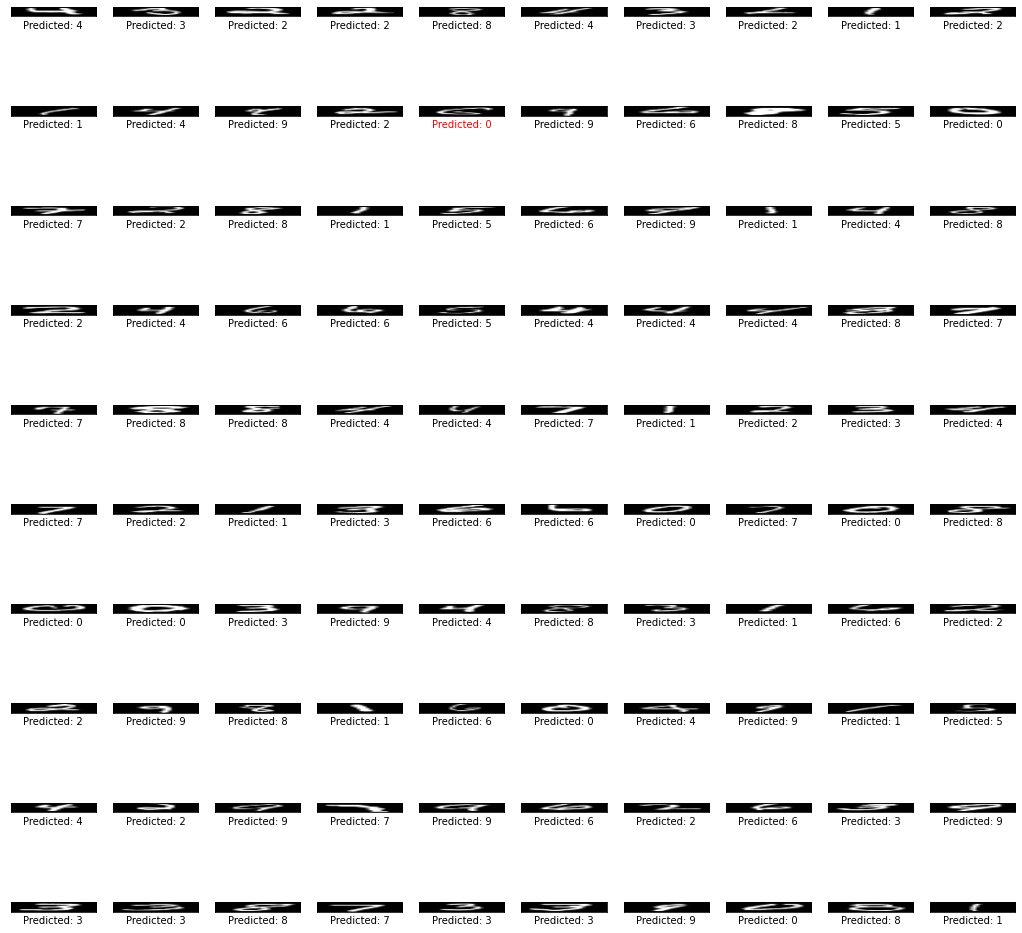

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_ds)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_ds[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Convert the Keras model to TensorFlow Lite

Now as we have trained the digit classifer model, we will convert it to TensorFlow Lite format for mobile deployment.

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp6c2444ks/assets


INFO:tensorflow:Assets written to: /tmp/tmp6c2444ks/assets


Float model size = 202KBs.


As we will deploy our model to a mobile device, we want our model to be as small and as fast as possible. **Quantization** is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

See [TensorFlow documentation](https://www.tensorflow.org/lite/performance/post_training_quantization) to learn more about other quantization techniques.

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: /tmp/tmpfmod__rs/assets


INFO:tensorflow:Assets written to: /tmp/tmpfmod__rs/assets


Quantized model size = 53KBs,
which is about 26% of the float model size.


## Evaluate the TensorFlow Lite model

By using quantization, we often traded off a bit of accuracy for the benefit of having a significantly smaller model. Let's calculate the accuracy drop of our quantized model.

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_ds:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9809
Quantized model accuracy = 0.9812
Accuracy drop = -0.0003


## Download the TensorFlow Lite model

Let's get our model and integrate it into an Android app.

If you see an error when downloading mnist.tflite from Colab, try running this cell again.

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()



In [ ]:
!pip install tflite-support

from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "IoTNet image classifier"
model_meta.description = ("Identify the most prominent object in the "
                          "image from a set of 10 digits")
model_meta.version = "v2"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(11, 100))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.GRAYSCALE)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
# input_normalization = _metadata_fb.ProcessUnitT()
# input_normalization.optionsType = (
#     _metadata_fb.ProcessUnitOptions.NormalizationOptions)
# input_normalization.options = _metadata_fb.NormalizationOptionsT()
# input_normalization.options.mean = [127.5]
# input_normalization.options.std = [127.5]
# input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
import os 

output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 10 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_VALUE_LABELS
output_meta.associatedFiles = [label_file]

In [ ]:

subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

In [ ]:

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
labelFile = open("labels.txt", "w")
labelFile.write("0,1,2,3,4,5,6,7,8,9")
labelFile.close()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file("mnist.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels.txt"])
populator.populate()

## Good job!
This is the end of *Step 2: Train a machine learning model* in the codelab **Build a handwritten digit classifier app with TensorFlow Lite**. Let's go back to our codelab and proceed to the [next step](https://codelabs.developers.google.com/codelabs/digit-classifier-tflite/#2).

In [ ]:
displayer = _metadata.MetadataDisplayer.with_model_file("mnist.tflite")
export_json_file = os.path.join("jsonFileFolder",
                    os.path.splitext("mnist.tflite")[0] + ".json")
json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
  f.write(json_file)

In [ ]:
# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.tflite` has been downloaded
